In [1]:
import tensorflow

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Convolution2DTranspose
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

# from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
#warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.13.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

data_dir = '/content/drive/MyDrive/Final Project/Final/dataset'

with zipfile.ZipFile(data_dir + '.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/image_dataset/2')

data_dir = '/tmp/image_dataset/2'

In [5]:
path = data_dir
def create_training_data(path):
  dataX=[]
  dataY=[]
  # enumerate filenames in directory, assume all are images
  for root, subdirs, files in os.walk(path+"/dataset/neutral/"):
    #print(root, subdirs, files)
    for filename in files:
      file_path = os.path.join(root, filename)
      #print(file_path)
      file_path = file_path.replace('\\', '/')
      img_array=cv2.imread(file_path)
      print("neutral--"+file_path)
      #print(len(np.array(img_array)))
      new_array=cv2.resize(img_array,(128,128))
      dataX.append(new_array)
  # enumerate filenames in directory, assume all are images
  for root, subdirs, files in os.walk(path+"/dataset/smile/"):
    for filename in files:
      file_path = os.path.join(root, filename)
      file_path = file_path.replace('\\', '/')
      img_array=cv2.imread(file_path)
      print("smile--"+file_path)
      #print(img_array)
      new_array=cv2.resize(img_array,(128,128))
      dataY.append(new_array)
  return dataX,dataY

In [6]:
IMG_SIZE = 128
dataX,dataY = create_training_data(path)
#dataX,dataY

neutral--/tmp/image_dataset/2/dataset/neutral/34.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/376.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/54.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/25.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/92.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/90.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/11.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/14.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/272.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/97.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/96.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/275.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/278.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/106.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/211.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/33.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/339.jpg
neutral--/tmp/image_dataset/2/dataset/neutral/308.jpg
neutral--/tmp/image_dataset/2/dataset/

In [7]:
(np.array(dataX[0])).shape

(128, 128, 3)

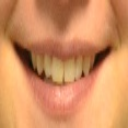

In [8]:
from google.colab.patches import cv2_imshow
cv2_imshow(dataY[0])

In [9]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.13.0


#InceptionV3

In [10]:
model_inception=InceptionV3(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

x=model_inception.output

87910968/87910968 [==============================] - 0s 0us/step


In [11]:
x = Convolution2DTranspose(512,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
x = Convolution2DTranspose(256,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
x = Convolution2DTranspose(128,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
x = Convolution2DTranspose(128,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
x = Convolution2DTranspose(64,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x)
preds=Convolution2DTranspose(3,kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding = "same")(x) #FC-layer

In [12]:
model=Model(inputs=model_inception.input,outputs=preds)

for layer in model.layers[:-8]:
    layer.trainable=False

for layer in model.layers[-8:]:
    layer.trainable=True

# use tensorflow.keras.losses.KLDivergence() for KL-Div loss function
model.compile(optimizer='Adam',loss='mae',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalization[0][0

In [13]:
dataX = np.array(dataX, dtype="float32") / 255.0
dataY = np.array(dataY, dtype="float32") / 255.0

In [14]:
(xtrain,xtest,ytrain,ytest)=train_test_split(dataX,dataY,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(157, 128, 128, 3) (40, 128, 128, 3) (157, 128, 128, 3) (40, 128, 128, 3)


In [15]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
model_path = "/content/drive/MyDrive/smile_dataset/2/dataset/Inception-v3-mae/model.h5"
checkpoint_path = "/content/drive/MyDrive/smile_dataset/2/dataset/Inception-v3-mae/checkpoint.ckpt"
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

In [ ]:
#skip
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)
datagen.fit(xtrain)
# Fits-the-model

history = model.fit(xtrain,ytrain, batch_size=32,
               steps_per_epoch=xtrain.shape[0]//32,
               epochs=1000,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_split = 0.1,
               validation_steps = xtest.shape[0]//32)

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.49570, saving model to /content/drive/MyDrive/smile_dataset/2/dataset/Inception-v3-mae/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 - 15s - loss: 0.8481 - accuracy: 0.3565 - val_loss: 0.4957 - val_accuracy: 0.3639 - lr: 0.0010 - 15s/epoch - 4s/step
Epoch 2/1000

Epoch 2: val_loss did not improve from 0.49570
4/4 - 2s - loss: 0.6168 - accuracy: 0.3556 - val_loss: 1.8768 - val_accuracy: 0.5073 - lr: 0.0010 - 2s/epoch - 453ms/step
Epoch 3/1000

Epoch 3: val_loss did not improve from 0.49570
4/4 - 0s - loss: 0.9993 - accuracy: 0.3707 - val_loss: 0.6291 - val_accuracy: 0.3838 - lr: 0.0010 - 359ms/epoch - 90ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.49570 to 0.38932, saving model to /content/drive/MyDrive/smile_dataset/2/dataset/Inception-v3-mae/model.h5
4/4 - 2s - loss: 0.4935 - accuracy: 0.4075 - val_loss: 0.3893 - val_accuracy: 0.5362 - lr: 0.0010 - 2s/epoch - 612ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 0.38932 to 0.35629, saving model to /content/drive/MyDrive/smile_dataset/2/dataset/Inception-v3-mae/model.h5
4/4 - 5s - loss: 0.4401 - accuracy: 0.4967 - val_loss: 0.3563 - val_accuracy: 0

In [ ]:
model.save_weights(checkpoint_path)

In [16]:
model.load_weights(checkpoint_path)

In [ ]:
temp = model.fit(xtrain,ytrain, batch_size=32,
               steps_per_epoch=xtrain.shape[0]//32,
               epochs=500,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_split = 0.1,
               validation_steps = xtest.shape[0]//32)

Epoch 1/500

Epoch 1: val_loss did not improve from 0.11285
4/4 - 0s - loss: 0.0215 - accuracy: 0.9890 - val_loss: 0.1185 - val_accuracy: 0.9891 - lr: 0.0010 - 492ms/epoch - 123ms/step
Epoch 2/500

Epoch 2: val_loss did not improve from 0.11285
4/4 - 0s - loss: 0.0208 - accuracy: 0.9910 - val_loss: 0.1195 - val_accuracy: 0.9881 - lr: 0.0010 - 357ms/epoch - 89ms/step
Epoch 3/500

Epoch 3: val_loss did not improve from 0.11285
4/4 - 0s - loss: 0.0194 - accuracy: 0.9907 - val_loss: 0.1171 - val_accuracy: 0.9898 - lr: 0.0010 - 342ms/epoch - 86ms/step
Epoch 4/500

Epoch 4: val_loss did not improve from 0.11285
4/4 - 0s - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.1192 - val_accuracy: 0.9878 - lr: 0.0010 - 330ms/epoch - 82ms/step
Epoch 5/500

Epoch 5: val_loss did not improve from 0.11285
4/4 - 0s - loss: 0.0180 - accuracy: 0.9906 - val_loss: 0.1179 - val_accuracy: 0.9897 - lr: 0.0010 - 337ms/epoch - 84ms/step
Epoch 6/500

Epoch 6: val_loss did not improve from 0.11285
4/4 - 0s - loss: 0.

In [ ]:
model.save_weights(checkpoint_path)

In [17]:
predY = model.predict(xtest)

2/2 [==============================] - 13s 1s/step


In [18]:
x_norm = predY
for i in range(len(predY)):
  x_norm[i]=((predY[i]-np.min(predY[i]))/(np.max(predY[i])-np.min(predY[i])))*255.0
  xtest[i]=((xtest[i]-np.min(xtest[i]))/(np.max(xtest[i])-np.min(xtest[i])))*255.0

In [19]:
x_norm.shape

(40, 128, 128, 3)

In [20]:
totalAcc = 0
mae = 0
for img in range(len(x_norm)):
  sumY = 0
  sumPred = 0
  for i in range(len(x_norm[img])):
    for j in range(len(x_norm[img][i])):
      for k in range(len(x_norm[img][i][j])):
        sumY = sumY+xtest[img][i][j][k]
        sumPred = sumPred+x_norm[img][i][j][k]
  error = np.abs(sumPred-sumY)
  diff = np.abs(1-(sumPred/sumY))
  acc = (1-diff)*100
  totalAcc = totalAcc+acc
  mae = mae + error
print("final acc ",totalAcc/len(x_norm))
print("mae ",mae/len(x_norm))

final acc  86.59599288735049
mae  983104.0703804387


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_test contains the true labels for the test data
y_pred = model.predict(xtest)

# Assuming y_pred contains the predicted labels
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)
from sklearn.metrics import mean_absolute_error

# Assuming y_test contains the true labels for the test data
y_pred = model.predict(xtest)

# Calculate MAE
mae = mean_absolute_error(ytest, y_pred)
print("Mean Absolute Error:", mae)


2/2 [==============================] - 0s 80ms/step


ValueError: ignored

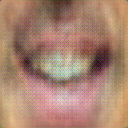

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(x_norm[0])

In [ ]:
np.max(x_norm)

255.0

In [ ]:
metric = tensorflow.keras.metrics.Accuracy()
metric.update_state(xtest*255.0,predY*255.0)
metric.result().numpy()

0.0

In [ ]:
true_values = np.array(xtest)
predictions = np.array(predY)

N = true_values.shape[1]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
precision = TP / (TP+FP)

In [ ]:
true_values.shape

In [ ]:
history = model.fit(xtrain,ytrain, batch_size=64,
               steps_per_epoch=xtrain.shape[0]/64,
               epochs=5000,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_split = 0.1)

In [ ]:
model.save_weights(checkpoint_path)